In [50]:
#run this cell to import the packages we need

import os
import pandas as pd
import numpy as np
#the following two packages are for plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
#this one is for doing some stats
import scipy.stats as stats

#the following line prevents pandas from giving unecessary errors 
pd.options.mode.chained_assignment = None

If you have saved the data file into a different folder than your current working directory (i.e., where you saved this python script), you'll need to change your working directory to where you saved the data 

Using the second line of code, change '..\\PhD_data\\BHO7' to wherever you saved the file (you'll have to change the slashes if you are not using windows)

Or if this python script and the data file are saved in the same location, comment out the second line

In [5]:
#check current working directory
os.getcwd()

#change working directory
os.chdir('..\\PhD_data\\BH07') 

Let's load in our data! 

I've given you a datafile with two sessions (session 29 and 30), so that the code will run relatively quickly.

Normally, we would be loading in a lot more data.

For this experiment, there are two groups - transgene positive rats (experimental) and transgene negative rats (control)


In [42]:
#we need to set a few variables for loading in the data - these will change depending on the dataset

#we are just loading in data from one file, but we could load data in from multiple files and combine them
file_names = ['BH07_raw_free_S29-30.xlsx'] 

group_names = ['Tg negative','Tg positive'] #control and experimental group, respectively

title = 'Nigrostriatal activation during acquisition' #title for figures, describing the experiment
startsess = 29 #first session in this dataset
endsess = 30 #last session in this dataset


#the following two lines of code assign the rat subject numbers to the experimental and control group lists
#you may notice there is no subject 10 - she died earlier in the experiment :( 
exp_group = [1, 2, 7, 8, 11, 12, 16, 19, 20, 21, 22, 25, 26, 29, 32] 

control_group = [3, 4, 5, 6, 9, 13, 14, 15, 17, 18, 23, 24, 27, 28, 30, 31]


In [6]:
#load in the data! As mentioned above, the code is written so that you can put in multiple file names and combine them
#in this case, we are only loading in one file

def load_data(fnames): 
    for i,file in enumerate(fnames):
        if i == 0:
            df = pd.read_excel(fnames[i]) #load in the first file from the 'file_names' list
        else:
            df2 = pd.read_excel(fnames[i]) #load in subsequent file
            df = df.append(df2, ignore_index = True) #append it to the first file
    return df

df = load_data(file_names)

In [7]:
#let's check the top few lines of the dataframe

df.head()

#it should look the same as the excel file 

,MSN,StartDate,StartTime,Subject,Group,Box,Experiment,Comment,Session,Trial,...,Pun_Persev_H5,Pun_HeadEntry,Pun_Dur,Premature_Resp,Premature_Hole,Rew_Persev_H1,Rew_Persev_H2,Rew_Persev_H3,Rew_Persev_H4,Rew_Persev_H5
0,rGT_A-cue,2020-10-09,11:01:00,25,0.0,1,0.0,NaN,29,1.0,...,3,3,30,0,0,0,0,0,0,0
1,rGT_A-cue,2020-10-09,11:01:00,25,0.0,1,0.0,NaN,29,2.1,...,0,0,0,1,5,0,0,0,0,0
2,rGT_A-cue,2020-10-09,11:01:00,25,0.0,1,0.0,NaN,29,2.0,...,3,2,30,0,0,0,0,0,0,0
3,rGT_A-cue,2020-10-09,11:01:00,25,0.0,1,0.0,NaN,29,3.0,...,0,0,0,0,0,0,0,0,0,0
4,rGT_A-cue,2020-10-09,11:01:00,25,0.0,1,0.0,NaN,29,4.0,...,2,2,30,0,0,0,0,0,0,0


Let's examine our data!

The following function will give us a summary of the session numbers +  session dates for each rat, plus the number of trials they did for each session (the rightmost column) 

This gives us a quick way to see if there are any missing or incorrect session numbers

Session numbers are typed in manually by the experimenter each day, so mistakes definitely happen :) 

We can also check to make sure that all the original data we want from MED-PC was exported into the excel file that we loaded in - sometimes one or two will get missed 


In [8]:
def check_sessions(df):
    pd.set_option('display.max_rows', None) #otherwise it will only display a few rows
    print(df.groupby(['Subject','StartDate','Session'])['Trial'].max())
    pd.set_option('display.max_rows',df.Subject.max()) #this sets the number of displayed rows to the number of subjects
    
check_sessions(df)

Subject  StartDate   Session
1        2020-10-09  29         131.1
         2020-10-10  30         124.0
2        2020-10-09  29          76.1
         2020-10-10  30          81.0
3        2020-10-09  29          49.0
         2020-10-10  30          45.0
4        2020-10-09  29         103.0
         2020-10-10  30          97.0
5        2020-10-09  29          68.1
         2020-10-10  30          69.0
6        2020-10-09  29          88.0
         2020-10-10  30          75.0
7        2020-10-09  28          53.0
         2020-10-10  29          65.0
         2020-10-13  30          56.1
8        2020-10-09  29         124.0
         2020-10-10  30         121.0
9        2020-10-09  29          62.0
         2020-10-10  30          61.0
11       2020-10-09  29         132.0
         2020-10-10  30         136.1
12       2020-10-09  29          54.0
         2020-10-10  30          72.0
13       2020-10-09  29          67.0
         2020-10-10  30          60.0
14       2020-10-09  

In [9]:
#if you look closely, we can see that three rats have an extra session (session 28)

#the following code will get rid of any session 28 data
#df.drop works by dropping the rows at the specified indices
#df.loc[df['Session']==28].index returns the index numbers for all session 28 data
#I then converted this to a list so the df.drop command would work properly 
df.drop(list(df.loc[df['Session']==28].index), inplace=True)
df.reset_index(inplace=True) #reset the index so there are no missing numbers 

#generally speaking, you should not use inplace=True, because it modifies the original dataframe
#usually it's better to make a copy
#i.e., df2 = df.drop(...) 
#until you are absolutely sure you are doing the manipulation that you want
#otherwise you will have to load in the original data again to correct any mistakes, which can be time consuming

In [10]:
#let's recheck the dataframe session numbers - you will see that each rat now only has two sessions

check_sessions(df)

Subject  StartDate   Session
1        2020-10-09  29         131.1
         2020-10-10  30         124.0
2        2020-10-09  29          76.1
         2020-10-10  30          81.0
3        2020-10-09  29          49.0
         2020-10-10  30          45.0
4        2020-10-09  29         103.0
         2020-10-10  30          97.0
5        2020-10-09  29          68.1
         2020-10-10  30          69.0
6        2020-10-09  29          88.0
         2020-10-10  30          75.0
7        2020-10-10  29          65.0
         2020-10-13  30          56.1
8        2020-10-09  29         124.0
         2020-10-10  30         121.0
9        2020-10-09  29          62.0
         2020-10-10  30          61.0
11       2020-10-09  29         132.0
         2020-10-10  30         136.1
12       2020-10-09  29          54.0
         2020-10-10  30          72.0
13       2020-10-09  29          67.0
         2020-10-10  30          60.0
14       2020-10-09  29          80.1
         2020-10-10  

Now that we've loaded in our data, the first thing we need to do is create an options column that specifies whether the rats chose P1, P2, P3 or P4, instead of the hole number (which is stored in the 'Chosen' column)

We need to make sure that we account for version A and version B

We can do this by referencing the MSN column in the dataframe 
MSN stands for 'MED-STATE NOTATION' which is the language that MEDPC programs are written in 
You can think of MSN as the task name

In [11]:
#let's check what MSNs we have in our dataframe
df['MSN'].unique()
#we can see that the tasks are called either A-cue or B-cue
#so we know whether a rat was run on version A or version B based on whether there is an 'A' or 'B' in the MSN column

array(['rGT_A-cue', 'rGT_B-cue'], dtype=object)

In [12]:
#this function sets up an option column with correct P1 to P4 configuration for version A and B
def get_choices(df):
    configA = np.array([1, 4, 0, 2, 3]) #this is the order for version A - i.e., hole 1 corresponds to P1
    configB = np.array([4, 1, 0, 3, 2]) #this is the order for version B - i.e., hole 1 corresponds to P4

    #I took the following code from someone else, so honestly I'm not entirely sure how it works haha
    #the important thing is that it uses the configurations above to assign the correct option, 
    #based on whether the MSN name contains 'A' or 'B'
    df['option'] = df['MSN'].str.contains("B").values*configB[df['Chosen'].astype('int').ravel()-1].astype('int') + \
        df['MSN'].str.contains("A").values*configA[df['Chosen'].astype('int').ravel()-1].astype('int')

    #the above code changes any zero in the chosen column to a three in the option column
    #so we need to fix that (zeros represent either a premature response or an omission)
    for i in range(len(df)):
        if df['Chosen'][i] == 0:
            df['option'][i] = 0
    return df

#let's run our function!
df = get_choices(df)

In [13]:
#we now have an option column that represents their P1-P4 choice
df['option']

0       3
1       0
2       3
3       3
4       3
       ..
6201    0
6202    0
6203    2
6204    4
6205    4
Name: option, Length: 6206, dtype: int32

Now that we know the P1 to P4 choice of each rat, we need to summarize this choice by converting it to a percentage

I.e., what is the percentage choice of each option for each rat, for each session?

The code for this is two different functions; the first can calculate the percentage choice for P1-P4 for a single session.
The second function uses the first one to calculate the %choice for all sessions

Note: this is by far the slowest function in this script, so I'm hoping to optimize in the future

In [17]:
#get %choice for a given session number (designated as the 'num' argument in this function)
def get_sum_choice(num, df):
    #first we create a df with only data from the given session number
    df1 = df.loc[df['Session'] == num]
    #then we create a list of subject numbers, and sort them
    subs = df1.Subject.unique()
    subs.sort()
    #then we create a df called percentage, which has 4 columns - P1 to P4, leading with the session number
    #i.e., if session number = 29, the columns will be 29P1, 29P2, 29P3, 29P4
    percentage = pd.DataFrame(columns=[str(num) + 'P1',str(num) + 'P2',str(num) + 'P3',str(num) + 'P4'])
    for sub in subs: #for each subject 
        for i,column in enumerate(percentage.columns): #for each option 
            #this calculates the %choice - number of times that option is selected divided by total number of choices,
            #multiplied by 100
            percentage.at[sub,column] = (len(df1.loc[(df1.option == i + 1) & 
                                            (df1.Subject == sub)]))/(len(df1.loc[(df1['option'] != 0) & 
                                                                                (df.Subject == sub)])) *100
    return percentage

#let's look at one instance of this function before moving on
df_summary = get_sum_choice(29, df)
df_summary #the index here is the subject numbers, 1-32

,29P1,29P2,29P3,29P4
1,90.8397,0,8.39695,0.763359
2,9.33333,65.3333,10.6667,14.6667
3,2.17391,8.69565,56.5217,32.6087
4,5.88235,73.5294,4.90196,15.6863
5,0,1.53846,98.4615,0
6,2.5,70,0,27.5
7,3.07692,10.7692,64.6154,21.5385
8,2.41935,92.7419,0.806452,4.03226
9,3.27869,3.27869,90.1639,3.27869
11,10.687,88.5496,0.763359,0


In [18]:
#now let's do it for all sessions - in this case 29 and 30
def get_sum_choice_all(df):
    #create an empty list to store the sessions individually
    df_sess = []
    for num in np.sort(df['Session'].unique()): #for each session number 
        df_sess.append(get_sum_choice(num,df)) #append the summary info from get_sum_choice to the above list
    #then turn that list into a df
    df1 = pd.concat(df_sess, axis=1)
    #let's also calculate the risk score for each session - (P1 + P2) - (P3 + P4)
    for num in np.sort(df['Session'].unique()):
        df1['risk'+ str(num)] = df1[str(num)+'P1'] + df1[str(num)+'P2']- df1[str(num)+'P3'] - df1[str(num)+'P4']
    return df1

#let's try it out! 
df_summary = get_sum_choice_all(df)
df_summary

,29P1,29P2,29P3,29P4,30P1,30P2,30P3,30P4,risk29,risk30
1,90.8397,0,8.39695,0.763359,83.0645,0,16.9355,0,81.6794,66.129
2,9.33333,65.3333,10.6667,14.6667,4.93827,76.5432,0,18.5185,49.3333,62.963
3,2.17391,8.69565,56.5217,32.6087,0,11.6279,67.4419,20.9302,-78.2609,-76.7442
4,5.88235,73.5294,4.90196,15.6863,13.4021,64.9485,3.09278,18.5567,58.8235,56.701
5,0,1.53846,98.4615,0,9.375,7.8125,79.6875,3.125,-96.9231,-65.625
6,2.5,70,0,27.5,2.94118,63.2353,0,33.8235,45,32.3529
7,3.07692,10.7692,64.6154,21.5385,1.81818,10.9091,69.0909,18.1818,-72.3077,-74.5455
8,2.41935,92.7419,0.806452,4.03226,2.47934,94.2149,1.65289,1.65289,90.3226,93.3884
9,3.27869,3.27869,90.1639,3.27869,5.26316,7.01754,82.4561,5.26316,-86.8852,-75.4386
11,10.687,88.5496,0.763359,0,8.14815,91.1111,0,0.740741,98.4733,98.5185


OK! Now that we have our choice data summarized, we can move on to the other variables - thankfully much more straightforward haha

First let's do percentage of premature responses. To calculate this, we need to sum up the total number of premature responses for each rat, and divide by the number of trials initiated (so premature trials and completed trials are both in the denominator).

From this point forward, we will be appending all subsequent variables to the df_summary we created above

So we need to pass both the raw data (df) and the summary data (df_summary) to each function

In [19]:
#extract premature response percentages from raw dataframe, and append it to the summary df
def get_premature(df_raw,df_sum):
    #add up the number of premature responses made by each subject for each session
    #save this information to a dataframe called prem_resp
    prem_resp = df_raw.groupby(['Subject', 'Session'],as_index=False)['Premature_Resp'].sum()
    
    #calculate the number of initiated trials for each subject for each session 
    prem_resp['Trials'] = df_raw.groupby(['Subject','Session'],as_index=False)['Trial'].count()['Trial']

    #calculate the premature percent by dividing number of premature responses by number of trials, times 100    
    prem_resp['prem_percent'] = prem_resp['Premature_Resp']/prem_resp['Trials'] * 100

    #add this information to the summary dataframe
    #the column name will be 'prem' + session number - i.e., prem29 for session 29
    for num in np.sort(df_raw['Session'].unique()): #for each session in the raw dataframe
        #for that session, extract the prem_percent column from prem_resp and add it to the summary dataframe
        #set the index as the subject number, so it matches the summary dataframe
        df_sum['prem' + str(num)] = prem_resp.loc[prem_resp['Session']==num].set_index('Subject')['prem_percent']
    return df_sum

#let's try it out!
df_summary = get_premature(df, df_summary)
df_summary

,29P1,29P2,29P3,29P4,30P1,30P2,30P3,30P4,risk29,risk30,prem29,prem30
1,90.8397,0,8.39695,0.763359,83.0645,0,16.9355,0,81.6794,66.129,26.404494,24.848485
2,9.33333,65.3333,10.6667,14.6667,4.93827,76.5432,0,18.5185,49.3333,62.963,30.275229,33.606557
3,2.17391,8.69565,56.5217,32.6087,0,11.6279,67.4419,20.9302,-78.2609,-76.7442,3.921569,6.250000
4,5.88235,73.5294,4.90196,15.6863,13.4021,64.9485,3.09278,18.5567,58.8235,56.701,13.445378,24.218750
5,0,1.53846,98.4615,0,9.375,7.8125,79.6875,3.125,-96.9231,-65.625,8.108108,16.867470
6,2.5,70,0,27.5,2.94118,63.2353,0,33.8235,45,32.3529,9.278351,15.730337
7,3.07692,10.7692,64.6154,21.5385,1.81818,10.9091,69.0909,18.1818,-72.3077,-74.5455,16.666667,34.523810
8,2.41935,92.7419,0.806452,4.03226,2.47934,94.2149,1.65289,1.65289,90.3226,93.3884,10.144928,12.949640
9,3.27869,3.27869,90.1639,3.27869,5.26316,7.01754,82.4561,5.26316,-86.8852,-75.4386,20.512821,11.594203
11,10.687,88.5496,0.763359,0,8.14815,91.1111,0,0.740741,98.4733,98.5185,2.222222,7.534247


Next, let's calculate our latencies! This is even simpler than premature responding because we don't need to calculate any additional information - we only need to find the mean value for each rat and session

The following function calculates the mean choice latency and mean collect latency for each rat and each session

In [21]:
def get_latencies(df_raw,df_sum):
    #extract only completed trials (including non-completed trials will skew the mean, as the latency is zero for those trials)
    df_raw = df_raw.loc[df_raw['Chosen'] != 0]
    #group by subject and session, then calculate the mean collect latency
    collect_lat = df_raw.groupby(['Subject','Session'],as_index=False)['Collect_Lat'].mean()
    #group by subject and session, then calculate the mean choice latency
    choice_lat = df_raw.groupby(['Subject','Session'],as_index=False)['Choice_Lat'].mean()
    
    #add this information to the summary dataframe - same method as used above for premature responding
    for num in np.sort(df_raw['Session'].unique()):
        df_sum['collect_lat' + str(num)] = collect_lat.loc[collect_lat['Session']==num].set_index('Subject')['Collect_Lat']
    for num in np.sort(df_raw['Session'].unique()):
        df_sum['choice_lat' + str(num)] = choice_lat.loc[choice_lat['Session']==num].set_index('Subject')['Choice_Lat']
    return df_sum

#let's run the function
df_summary = get_latencies(df, df_summary)
df_summary

,29P1,29P2,29P3,29P4,30P1,30P2,30P3,30P4,risk29,risk30,prem29,prem30,collect_lat29,collect_lat30,choice_lat29,choice_lat30
1,90.8397,0,8.39695,0.763359,83.0645,0,16.9355,0,81.6794,66.129,26.404494,24.848485,0.929160,1.058226,0.638321,0.655323
2,9.33333,65.3333,10.6667,14.6667,4.93827,76.5432,0,18.5185,49.3333,62.963,30.275229,33.606557,1.157333,1.010617,1.057733,1.249012
3,2.17391,8.69565,56.5217,32.6087,0,11.6279,67.4419,20.9302,-78.2609,-76.7442,3.921569,6.250000,0.467174,0.549070,2.833261,3.652791
4,5.88235,73.5294,4.90196,15.6863,13.4021,64.9485,3.09278,18.5567,58.8235,56.701,13.445378,24.218750,0.904412,0.817938,1.000980,0.885258
5,0,1.53846,98.4615,0,9.375,7.8125,79.6875,3.125,-96.9231,-65.625,8.108108,16.867470,0.397385,0.618125,3.135846,3.176250
6,2.5,70,0,27.5,2.94118,63.2353,0,33.8235,45,32.3529,9.278351,15.730337,0.739000,0.686618,2.172000,1.859265
7,3.07692,10.7692,64.6154,21.5385,1.81818,10.9091,69.0909,18.1818,-72.3077,-74.5455,16.666667,34.523810,0.439077,0.473273,1.012615,1.194545
8,2.41935,92.7419,0.806452,4.03226,2.47934,94.2149,1.65289,1.65289,90.3226,93.3884,10.144928,12.949640,1.401532,1.353884,1.850484,1.956033
9,3.27869,3.27869,90.1639,3.27869,5.26316,7.01754,82.4561,5.26316,-86.8852,-75.4386,20.512821,11.594203,0.367869,0.349474,2.300328,2.754211
11,10.687,88.5496,0.763359,0,8.14815,91.1111,0,0.740741,98.4733,98.5185,2.222222,7.534247,1.116794,1.246519,1.950153,1.667852


Ok, we're almost done creating our summary dataframe. We only have two variables to go - omissions and trials completed

These ones are straightforward - for omissions, we will simply count them (they're coded as a 1 in the raw dataframe, so we can just sum the column for each rat/session)

For trials, we will take the max number in the trials column of the raw dataframe


I'm going to put these two functions together, since they have the same structure as the functions above

In [25]:
def get_omit(df_raw,df_sum):
    #group by subject and session and sum the 'omit' column
    omit = df_raw.groupby(['Subject','Session'],as_index=False)['Omit'].sum()
    #append this information to the summary dataframe
    for num in np.sort(df_raw['Session'].unique()):
        df_sum['omit' + str(num)] = omit.loc[omit['Session']==num].set_index('Subject')['Omit']
    return df_sum

def get_trials(df_raw,df_sum):
    #group by subject and session and get the max number in the trial column
    trials = df_raw.groupby(['Subject','Session'],as_index=False)['Trial'].max()
    #append this information ot the summary dataframe
    for num in np.sort(df_raw['Session'].unique()):
        df_sum['trial' + str(num)] = trials.loc[trials['Session']==num].set_index('Subject')['Trial']
    return df_sum

df_summary = get_omit(df, df_summary)
df_summary = get_trials(df, df_summary)

In [26]:
#let's look at our completed summary dataframe - yay!

df_summary

,29P1,29P2,29P3,29P4,30P1,30P2,30P3,30P4,risk29,risk30,prem29,prem30,collect_lat29,collect_lat30,choice_lat29,choice_lat30,omit29,omit30,trial29,trial30
1,90.8397,0,8.39695,0.763359,83.0645,0,16.9355,0,81.6794,66.129,26.404494,24.848485,0.929160,1.058226,0.638321,0.655323,0,0,131.1,124.0
2,9.33333,65.3333,10.6667,14.6667,4.93827,76.5432,0,18.5185,49.3333,62.963,30.275229,33.606557,1.157333,1.010617,1.057733,1.249012,1,0,76.1,81.0
3,2.17391,8.69565,56.5217,32.6087,0,11.6279,67.4419,20.9302,-78.2609,-76.7442,3.921569,6.250000,0.467174,0.549070,2.833261,3.652791,3,2,49.0,45.0
4,5.88235,73.5294,4.90196,15.6863,13.4021,64.9485,3.09278,18.5567,58.8235,56.701,13.445378,24.218750,0.904412,0.817938,1.000980,0.885258,1,0,103.0,97.0
5,0,1.53846,98.4615,0,9.375,7.8125,79.6875,3.125,-96.9231,-65.625,8.108108,16.867470,0.397385,0.618125,3.135846,3.176250,3,5,68.1,69.0
6,2.5,70,0,27.5,2.94118,63.2353,0,33.8235,45,32.3529,9.278351,15.730337,0.739000,0.686618,2.172000,1.859265,8,7,88.0,75.0
7,3.07692,10.7692,64.6154,21.5385,1.81818,10.9091,69.0909,18.1818,-72.3077,-74.5455,16.666667,34.523810,0.439077,0.473273,1.012615,1.194545,0,0,65.0,56.1
8,2.41935,92.7419,0.806452,4.03226,2.47934,94.2149,1.65289,1.65289,90.3226,93.3884,10.144928,12.949640,1.401532,1.353884,1.850484,1.956033,0,0,124.0,121.0
9,3.27869,3.27869,90.1639,3.27869,5.26316,7.01754,82.4561,5.26316,-86.8852,-75.4386,20.512821,11.594203,0.367869,0.349474,2.300328,2.754211,1,4,62.0,61.0
11,10.687,88.5496,0.763359,0,8.14815,91.1111,0,0.740741,98.4733,98.5185,2.222222,7.534247,1.116794,1.246519,1.950153,1.667852,1,0,132.0,136.1


In [ ]:
#we can also write a function that runs all the above functions to create the summary dataframe
#I don't recommend running this because it will do what we already did, and is kind of slow haha
# so it's just an FYI :)

def get_summary_data(df_raw):
    df_raw = get_choices(df_raw)
    df_sum = get_sum_choice_all(df_raw)
    df_sum = get_latencies(df_raw,df_sum)
    df_sum = get_omit(df_raw,df_sum)
    df_sum = get_trials(df_raw,df_sum)
    df_sum = get_premature(df_raw,df_sum)
    return df_sum

df_summary = get_summary_data(df)



In [38]:
#one more thing we can do - assign rats as risky or optimal, depending on their risk score

def get_risk_status(df_sum, startsess, endsess):
    #get risk status from specified sessions
    #create lists for indexing based on risk status
    risky = []
    optimal = []
    startsess = 'risk' + str(startsess)
    endsess = 'risk' + str(endsess)
    #calculate the mean risk score from the specified sessions
    df_sum['mean_risk'] = df_sum.loc[:,startsess:endsess].mean(axis=1)
    for sub in df_sum.index: #for each subject
        if df_sum.at[sub,'mean_risk'] > 0: #if the mean risk for that subject is above zero
            df_sum.at[sub,'risk_status'] = 1 #assign them a risk status of 1
            optimal.append(sub) #and add them to the 'optimal' list
        elif df_sum.at[sub,'mean_risk'] < 0: #if the mean risk for that subject is below zero
            df_sum.at[sub,'risk_status'] = 2 #assign them a risk status of 2
            risky.append(sub) #and append them to the 'risky' list
    return df_sum, risky, optimal

df_summary, risky, optimal = get_risk_status(df_summary, startsess, endsess) 
#remember, startsess and endsess were defined at the beginning of this script

print(df_summary[['mean_risk','risk_status']])
print(risky, optimal)

    mean_risk  risk_status
1   73.904211          1.0
2   56.148148          1.0
3  -77.502528          2.0
4   57.762280          1.0
5  -81.274038          2.0
6   38.676471          1.0
7  -73.426573          2.0
8   91.855505          1.0
9  -81.161921          2.0
11  98.495900          1.0
12  32.942097          1.0
13 -33.705357          2.0
14  43.214286          1.0
15 -41.344124          2.0
16 -30.296896          2.0
17   0.633446          1.0
18  41.629689          1.0
19   4.054054          1.0
20  91.116505          1.0
21  11.868687          1.0
22  62.978469          1.0
23  75.345912          1.0
24  71.178218          1.0
25 -98.437500          2.0
26  35.270270          1.0
27  44.732745          1.0
28  43.102453          1.0
29 -30.433996          2.0
30  94.573643          1.0
31  80.796731          1.0
32   1.587302          1.0
[3, 5, 7, 9, 13, 15, 16, 25, 29] [1, 2, 4, 6, 8, 11, 12, 14, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 30, 31, 32]


Ok so now we have our beautiful summary dataframe! There are two things that we can do with this:

1.) export the summary df to an excel file, which we can import into SPSS to run stats on. For this to be the most useful, we will also create a column that specifies whether the rat is in the control group or experimental group

2.) calculate the means for the experimental group and the control group, to create figures

In [41]:
'''this function will save the dataframe as an excel file
groups is a list of lists - i.e., a list of the control group list and the experimental group list which we defined
at the start of this script.
groupname is the name of the column that will specify control vs experimental - in this case we want it to be
transgene status (or tg_status for short)
filename is the name of the exported excel sheet.
'''
def export_to_excel(df,groups,groupname,filename):
    dfs = []
    for group in groups: #this splits the dataframe by group
        dfs.append(df.loc[group])
    for i,df in enumerate(dfs): #this assigns a number to the tg_status column - in this case, 0 for control, 1 for experimental
        df[groupname] = i
    df_export = pd.concat(dfs) #this recombines the dataframes
    df_export.sort_index(inplace = True) #this sorts the subjects so they're in the right order after combining
    df_export.to_excel(filename, index_label = 'Subject')

#the filename I've chosen is BH07_free_S29-30 - same as the original filename except without 'raw', since it's summary data
export_to_excel(df_summary, [control_group, exp_group], 'tg_status', 'BH07_free_S29-30.xlsx')

#it should now be in your current working directory!

In [45]:
#ok, let's create a dataframe that has the means for each variable for experimental vs control group
#we'll also create a second dataframe that has the standard error of the means

def get_group_means_sem(df_sum,groups, group_names):
    dfs = []
    #first split the dataframe based on experimental vs control
    for group in groups:
        dfs.append(df_sum.loc[group])
    #create two dataframes - one for the means, one for the SEM
    mean_scores = pd.DataFrame(columns=list(df_sum.columns))
    stderror = pd.DataFrame(columns=mean_scores.columns)
    #calculate the mean and standard errors, and store them in the above dataframes
    for column in mean_scores.columns:
        for i in range(len(groups)):
            mean_scores.at[i,column] = dfs[i][column].mean()
            stderror.at[i,column] = stats.sem(dfs[i][column])
    #rename the rows to be the group_names (i.e., transgene positive and transgene negative)   
    mean_scores.rename(index=group_names,inplace = True)
    stderror.rename(index=group_names, inplace = True)
    return mean_scores, stderror

#for the renaming to work, group_names needs to be a dictionary
group_names = {0: 'tg negative',
              1: 'tg positive'}

mean_scores, stderror = get_group_means_sem(df_summary, [control_group, exp_group], group_names)

mean_scores

,29P1,29P2,29P3,29P4,30P1,30P2,30P3,30P4,risk29,risk30,...,collect_lat29,collect_lat30,choice_lat29,choice_lat30,omit29,omit30,trial29,trial30,mean_risk,risk_status
tg negative,5.74901,50.9906,33.8409,9.41941,7.24256,53.3089,28.8852,10.5634,13.4793,21.1029,...,0.878112,0.945107,2.10245,2.07925,3.25,3.5,77.4563,83.0812,17.2911,1.3125
tg positive,16.0466,45.0598,21.712,17.1815,14.8991,45.8362,22.0626,17.2021,22.2129,21.4706,...,0.974579,0.928688,1.77515,1.82612,1.53333,2.73333,86.56,85.0267,21.8417,1.26667


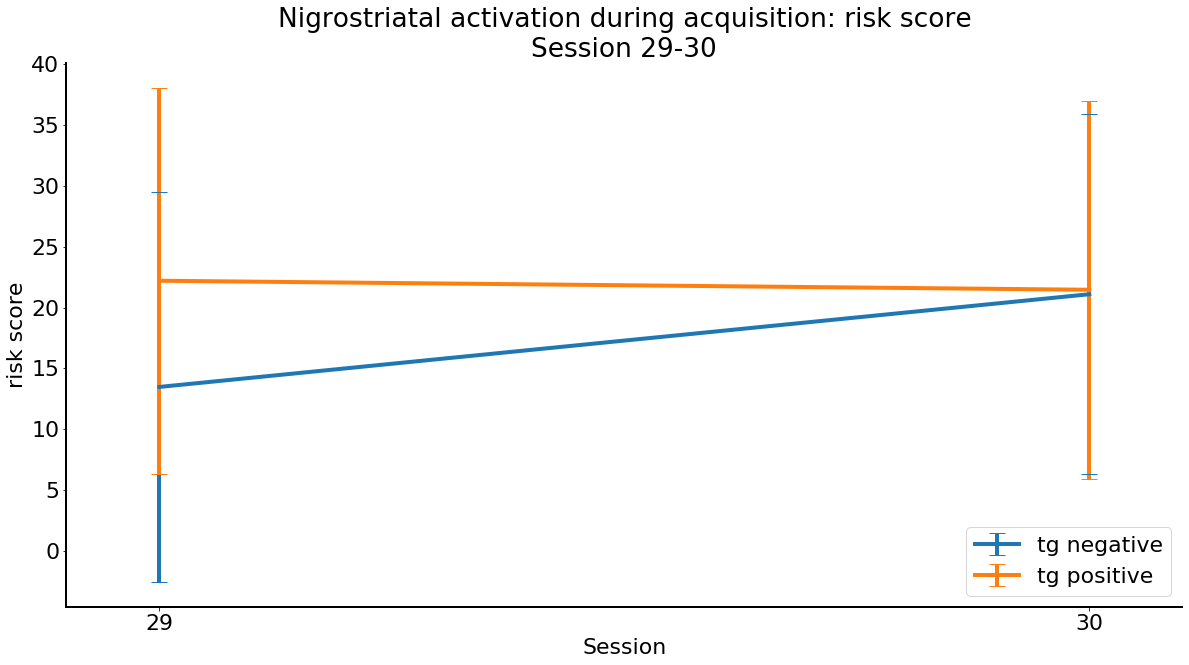

In [59]:
#now we can create a figure! 

def rgt_plot(variable,startsess,endsess,group_names,title,scores,sem, highlight = None, var_title = None):
    if var_title == None:
        var_title = variable
    plt.rcParams.update({'font.size': 22})
    fig,ax = plt.subplots(figsize = (20,10))
    ax.set_ylabel(var_title)
    ax.set_xlabel('Session')
    ax.set_xlim(startsess,endsess)
    ax.set_title(title + ': ' + var_title + '\n' + 'Session ' + str(startsess) + '-' + str(endsess))
    ax.spines['right'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.set_xlim(startsess-.1,endsess+.1)
    x=np.arange(startsess,endsess+1)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
   
    for i,group in enumerate(group_names):
        y = scores.loc[group,variable+str(startsess):variable+str(endsess)]
        plt.errorbar(x, y,
                     yerr = sem.loc[group,variable+str(startsess):variable+str(endsess)], 
                     label=group,linewidth=4, capsize = 8)
    if highlight != None:
        plt.axvline(highlight, 0, 1, color = 'gray', lw = 1)
        ax.fill_between([highlight,endsess], ax.get_ylim()[0], ax.get_ylim()[1], facecolor='gray', alpha=0.2)
    ax.legend()
    
rgt_plot('risk',startsess,endsess,['tg negative','tg positive'],title,mean_scores,stderror, var_title='risk score')

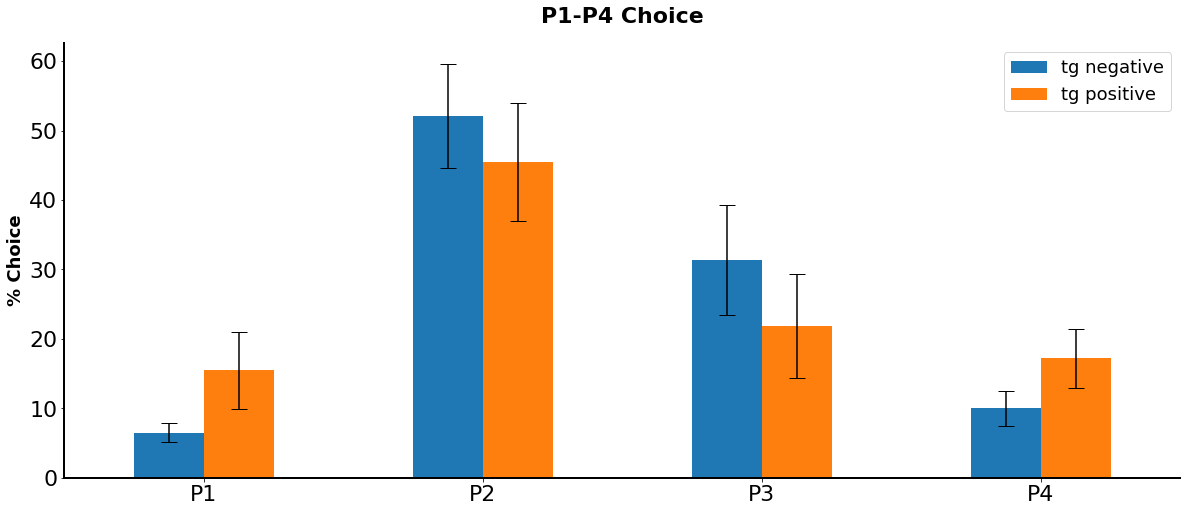

In [48]:
def choice_bar_plot(startsess, endsess, scores, sem,cmap = 'default'):
    sess = list(range(startsess,endsess + 1))
    labels = ['P1','P2','P3','P4']
    df = pd.DataFrame()
    df1 = pd.DataFrame()
    if cmap == 'Paired':
        colors = [plt.cm.Paired(5),plt.cm.Paired(1),plt.cm.Paired(4),plt.cm.Paired(0)]
    if cmap == 'default':
        colors = [plt.cm.Set1(1),plt.cm.Set1(0)]
    for choice in labels:
        df[choice] = scores.loc[:, [col for col in scores.columns if choice in col 
                                    and int(col[:col.index('P')]) in sess]].mean(axis = 1)
        df1[choice] = sem.loc[:, [col for col in scores.columns if choice in col 
                                    and int(col[:col.index('P')]) in sess]].mean(axis = 1)
    ax = df.transpose().plot.bar(rot = 0, yerr = df1.transpose(), capsize = 8, figsize = (20,8))
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    plt.rcParams.update({'font.size': 18})
    ax.set_ylabel('% Choice', fontweight = 'bold', fontsize = 18)
    ax.set_title('P1-P4 Choice', fontweight = 'bold', fontsize = 22, pad = 20)
    ax.set_ylim(bottom = 0)
    ax.spines['right'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.legend()
    
choice_bar_plot(startsess,endsess,mean_scores,stderror)